<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Alejandra Rico Rosales, Diego Alberto López Lazareno.

**Fecha:** 23 de octubre del 2021.

**Expediente:** 720838, 714643.
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github:** [Link con el enlace del repositorio del creador del proyecto](https://github.com/alerrico/Tarea8_ARico_DALopez)

# Tarea 8: Clase 22

In [1]:
# Librerías necesarias
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Funciones necesarias
def options_yf(ticker : "Ticker en formato string"):
    """
    options_yf descarga información de opciones financieras con ayuda de yfinance. Retorna:
    *calls : un diccionario con los calls a distintas fechas de vencimiento.
    *puts : un diccionario con los puts a distintas fechas de vencimiento.
    
    *ticker : es el símbolo de cotización de la acción
    
    """
    stock = yf.Ticker(ticker)
    calls, puts = {}, {}
    
    def options_yf_(n):
        nonlocal stock
        calls[stock.options[n]] = stock.option_chain(stock.options[n])[0]
        puts[stock.options[n]] = stock.option_chain(stock.options[n])[1]
    
    [options_yf_(n) for n in range(len(stock.options))]
    
    return calls, puts

def valuacionPut(ticker, fechaInicio, precioEjercicio, fechaExpiracion, rf, escenarios, 
                  metodo : "Rendimientos simples, Rendimientos logarítmicos, Modelo Normal, Histograma"):
    """
    valuacionPut valora una opción financiera del tipo Put. Retorna:
    resultados : una lista con la prima del Put y el intervalo de confianza para dicha prima.
    
    *ticker : es el símbolo de cotización de la acción.
    *fechaInicio : es la fecha de inicio para la descarga de los precios históricos de la acción.
    *precioEjercicio : es el precio de ejercicio del Put.
    *fechaExpiracion : es la fecha en la que expira el contrato Put.
    *rf : es la tasa libre de riesgo (en base diaria).
    *escenarios : son los escenarios a simular.
    *metodo : Rendimientos simples, Rendimientos logarítmicos, Modelo Normal (modelo normal para los rendimientos), 
    Histograma (usando el histograma de los rendimientos)
    
    """
    
    # Descarga de precios de cierre históricos para la acción
    precios = yf.download(ticker, start = fechaInicio, end = None, progress = False)["Adj Close"]
    precioInicial = precios.iloc[-1]
    
    # Metodología para el cálculo de los rendimientos
    if metodo == "Rendimientos simples":
        rendimiento = precios.pct_change().dropna()
        media = rendimiento.mean()
        volatilidad = rendimiento.std()
        
    elif metodo == "Rendimientos logarítmicos":
        rendimiento = np.log(precios / precios.shift(1)).dropna()
        media = rendimiento.mean()
        volatilidad = rendimiento.std()
        
    elif metodo == "Modelo Normal":
        rendimiento = np.log(precios / precios.shift(1)).dropna()
        volatilidad = rendimiento.std()
        
    else:
        rendimiento = np.log(precios / precios.shift(1)).dropna()
        media = rendimiento.mean()
        volatilidad = rendimiento.std()

    # Simulación de precios
    fechas = pd.date_range(start = datetime.date.today(), end = fechaExpiracion, freq = "B") 
    dias = len(fechas)
    
    if metodo == "Rendimientos simples" or metodo == "Rendimientos logarítmicos":
        Z = np.random.randn(dias, escenarios)
        rendimientosSimulados = pd.DataFrame(media + Z * volatilidad, index = fechas)
        
        if metodo == "Rendimientos simples":
            preciosSimulados = precioInicial * (rendimientosSimulados + 1).cumprod()
            preciosSimulados.iloc[0, :] = precioInicial 
    
        else:
            preciosSimulados = precioInicial * np.exp(rendimientosSimulados.cumsum())
            preciosSimulados.iloc[0, :] = precioInicial 
        
    elif metodo == "Modelo Normal":
        Z = np.random.randn(dias, escenarios)
        rendimientosSimulados = pd.DataFrame(volatilidad * Z + rf, index = fechas)
        preciosSimulados = precioInicial * np.exp(rendimientosSimulados.cumsum())
        preciosSimulados.iloc[0, :] = precioInicial
        
    else:
        y, x = np.histogram(rendimiento + rf - media, bins = 2000)
        y = y / np.sum(y)
        rendimientosSimulados_ = np.random.choice(x[1:], dias * escenarios, p = y)
        rendimientosSimulados = pd.DataFrame(rendimientosSimulados_.reshape((dias, escenarios)), index = fechas)
        preciosSimulados = precioInicial * np.exp(rendimientosSimulados.cumsum())
        
    # Valuación
    if metodo == "Simple" or metodo == "Logarítmico":
        put = pd.DataFrame({"Prima" : np.exp(-media * dias) * np.fmax(precioEjercicio - preciosSimulados, 0).mean(axis = 1)}, 
                           index = fechas) 
    else:
        put = pd.DataFrame({"Prima" : np.exp(-rf * dias) * np.fmax(precioEjercicio - preciosSimulados, 0).mean(axis = 1)}, 
                           index = fechas) 
    
    intervaloConfianza = st.norm.interval(0.99, loc = put.iloc[-1].values[0], scale = st.sem(preciosSimulados.iloc[-1]))
    
    # Resultados
    resultados = [put.iloc[-1].values[0], intervaloConfianza[0], intervaloConfianza[1]]
    put.plot(figsize = (8, 5), title = metodo)
        
    return resultados
    
def blackScholesPut(ticker, fechaInicio, precioEjercicio, fechaExpiracion, rf):
    """
    blackScholesPut valora una opción financiera del tipo Put a través del Modeo de Black and Scholes. Retorna:
    *put : la prima del contrato.
    
    *ticker : es el símbolo de cotización de la acción.
    *fechaInicio : es la fecha de inicio para la descarga de los precios históricos de la acción.
    *precioEjercicio : es el precio de ejercicio del Put.
    *fechaExpiracion : es la fecha en la que expira el contrato Put.
    *rf : es la tasa libre de riesgo (en base diaria).
    
    """
    
    # Descarga de precios de cierre históricos para la acción
    precios = yf.download(ticker, start = fechaInicio, end = None, progress = False)["Adj Close"]
    precioInicial = precios.iloc[-1]
    
    # Rendimientos logarítmicos
    rendimiento = np.log(precios / precios.shift(1)).dropna()
    volatilidad = rendimiento.std()
    
    # Black and Scholes
    dias = len(pd.date_range(start = datetime.date.today(), end = fechaExpiracion, freq = "B"))
    
    d1 = (np.log(precioInicial / precioEjercicio) + (rf + 0.5 * volatilidad ** 2) * dias) / (volatilidad * np.sqrt(dias))
    d2 = (np.log(precioInicial / precioEjercicio) + (rf - 0.5 * volatilidad ** 2) * dias) / (volatilidad * np.sqrt(dias))
    
    put = precioEjercicio * np.exp(-rf * dias) * st.norm.cdf(-d2)  - precioInicial * st.norm.cdf(-d1) 
    
    return put

## Enunciado de tarea (Transcribirlo)

> Replicar el procedimiento anterior para valoración de opciones 'call', pero en este caso para opciones tipo 'put' y además deben de comparar con los resultados teoricos del método de valuación de Black-Scholes (ecuación del principio de clase)

#### Código de solución `ESTUDIANTE 1: ALEJANDRA RICO`

In [3]:
# Descarga de información de opciones financieras 
ticker = "AAPL"
fechaExpiracion = "2022-01-21"

calls , puts = options_yf(ticker)
puts = puts[fechaExpiracion][(puts[fechaExpiracion]["strike"] >= 100) & (puts[fechaExpiracion]["strike"] <= 150)]
puts

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
46,AAPL220121P00100000,2021-11-19 19:47:57,100.00,0.12,0.12,0.13,-0.03,-20.000004,1137.0,48432,0.507817,False,REGULAR,USD
47,AAPL220121P00102500,2021-11-18 20:59:36,102.50,0.17,0.15,0.16,0.00,0.000000,6.0,26130,0.500982,False,REGULAR,USD
48,AAPL220121P00103750,2021-11-19 19:27:38,103.75,0.15,0.16,0.17,-0.05,-24.999998,27.0,9664,0.493169,False,REGULAR,USD
49,AAPL220121P00105000,2021-11-19 18:56:20,105.00,0.16,0.16,0.17,-0.05,-23.809523,719.0,38422,0.480962,False,REGULAR,USD
50,AAPL220121P00106250,2021-11-19 19:41:51,106.25,0.17,0.15,0.17,-0.07,-29.166666,2.0,10674,0.468755,False,REGULAR,USD
51,AAPL220121P00107500,2021-11-19 15:06:03,107.50,0.21,0.16,0.18,0.00,0.000000,10.0,8698,0.460943,False,REGULAR,USD
52,AAPL220121P00108750,2021-11-19 19:40:27,108.75,0.19,0.17,0.19,-0.05,-20.833332,3.0,7625,0.453130,False,REGULAR,USD
53,AAPL220121P00110000,2021-11-19 19:40:25,110.00,0.20,0.18,0.20,-0.05,-19.999998,167.0,52040,0.444830,False,REGULAR,USD
54,AAPL220121P00111250,2021-11-19 15:28:11,111.25,0.23,0.19,0.21,-0.07,-23.333336,20.0,8242,0.436529,False,REGULAR,USD
55,AAPL220121P00112500,2021-11-19 19:12:52,112.50,0.22,0.20,0.22,-0.05,-18.518522,1.0,15831,0.427740,False,REGULAR,USD


> A continuación se valorará la opción **AAPL220121P00125000** con los métodos vistos en clase.

In [4]:
# Valoración Modelo de Black & Scholes
fechaInicio = "2016-01-01" 
indicePut = 72
precioEjercicio = puts.loc[indicePut].strike 
rf = 0.0018 / 360 
N = 10000 

primaReal = puts.loc[indicePut].lastPrice 
primaTeorica = blackScholesPut(ticker, fechaInicio, precioEjercicio, fechaExpiracion, rf)
resultados = pd.DataFrame({"Prima Real" : primaReal, "Prima Teórica B&S" : primaTeorica}, 
                         index = ["Put: K = " + str(precioEjercicio) + ", Vencimiento = " + fechaExpiracion])

resultados["% Error relativo (prima real)"] = np.round(abs(primaTeorica - primaReal) / primaReal * 100, 2)
resultados

,Prima Real,Prima Teórica B&S,% Error relativo (prima real)
"Put: K = 150.0, Vencimiento = 2022-01-21",2.46,3.711431,50.87


> Con el Modelo Black & Scholes obtenemos una prima de 3.71, este resultado está 50.87% alejado de nuestra prima real, 2.46. Este error podría deberse a los supuestos que utiliza el Modelo Black & Scholes.

,Prima,Límite inferior (99% confianza),Límite superior (99% confianza),% Error relativo (prima real),% Error relativo (prima teórica B&S)
Rendimientos simples,1.577225,1.015442,2.139008,35.89,57.50
Rendimientos logarítmicos,1.512891,0.956907,2.068875,38.50,59.24
Modelo Normal,3.443842,2.923062,3.964623,39.99,7.21
Histograma,3.166707,2.645091,3.688323,28.73,14.68


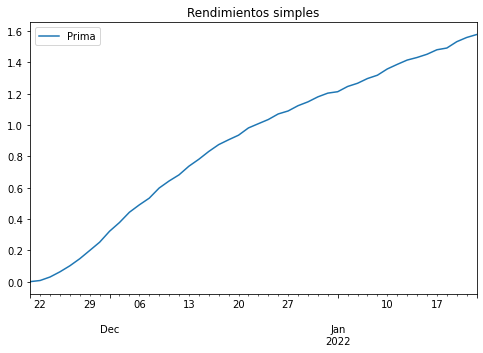

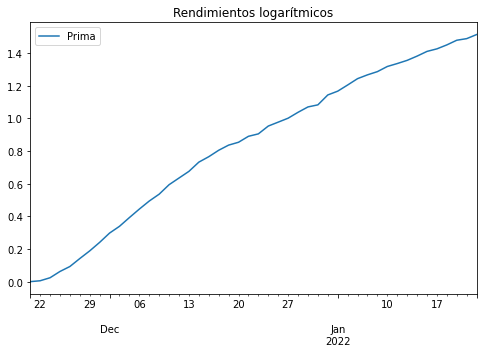

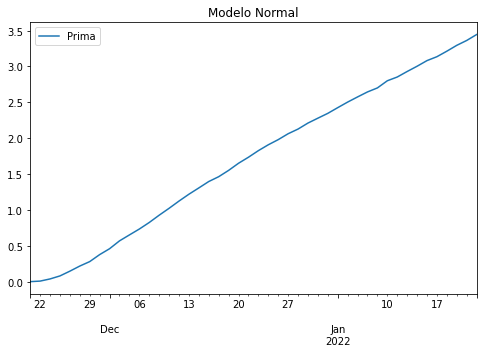

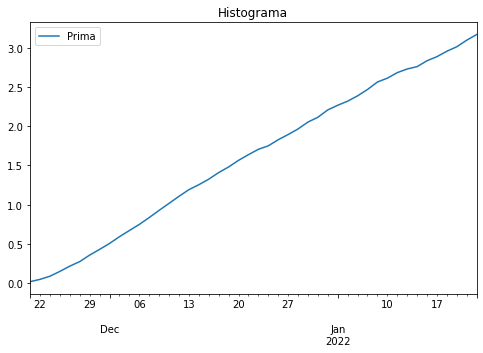

In [5]:
# Valoración distintos métodos
metodos = ["Rendimientos simples", "Rendimientos logarítmicos", "Modelo Normal", "Histograma"]
primas = pd.DataFrame([valuacionPut(ticker, fechaInicio, precioEjercicio, fechaExpiracion, rf, N, metodo) 
                       for metodo in metodos],
                       columns = ["Prima", "Límite inferior (99% confianza)", "Límite superior (99% confianza)"], 
                       index = metodos)

primas["% Error relativo (prima real)"] = np.round(abs(primas["Prima"] - primaReal) / primaReal * 100, 2)
primas["% Error relativo (prima teórica B&S)"] = np.round(abs(primas["Prima"] - primaTeorica) / primaTeorica * 100, 2)
primas

> Al utilizar estos 4 métodos, podemos obervar que en todos los escenarios obtenemos primas muy cercanas a nuestra prima real. Sin embargo los errores relativos más altos, tanto para la prima real como para la prima teórica de B&S, los presentan los métodos de los rendimientos simples y los rendimientos logarítmicos. Por lo que podemos concluir, basándonos en el error, que el Modelo Normal y el Histogama son los métodos más certeros para valorar las opciones. 

#### Código de solución `ESTUDIANTE 2: DIEGO LOPEZ`

In [6]:
# Descarga de información de opciones financieras 
ticker = "MSFT"
fechaExpiracion = "2022-01-21"

calls , puts = options_yf(ticker)
puts = puts[fechaExpiracion][(puts[fechaExpiracion]["strike"] >= 340) & (puts[fechaExpiracion]["strike"] <= 370)]
puts

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
54,MSFT220121P00340000,2021-11-19 19:58:58,340.0,10.36,10.30,10.45,-1.190001,-10.303035,526,2968,0.209603,False,REGULAR,USD
55,MSFT220121P00345000,2021-11-19 19:54:39,345.0,12.65,12.55,12.75,-1.230001,-8.861674,201,619,0.205330,True,REGULAR,USD
56,MSFT220121P00350000,2021-11-19 19:35:24,350.0,15.40,15.25,15.40,-1.400000,-8.333332,17,839,0.201302,True,REGULAR,USD
57,MSFT220121P00355000,2021-11-19 19:21:59,355.0,18.15,18.35,18.50,-1.850000,-9.250002,27,357,0.199349,True,REGULAR,USD
58,MSFT220121P00360000,2021-11-19 18:40:56,360.0,22.10,21.75,21.95,-1.449999,-6.157107,31,417,0.198098,True,REGULAR,USD
59,MSFT220121P00365000,2021-11-19 18:50:33,365.0,25.65,25.40,25.70,-1.600000,-5.871561,13,328,0.197091,True,REGULAR,USD
60,MSFT220121P00370000,2021-11-19 17:14:40,370.0,28.93,29.50,29.85,-8.669998,-23.058506,8,315,0.199898,True,REGULAR,USD


Primeramente se descarga la información de **opciones del tipo Put para MSFT** (Microsoft), cuya fecha de expiración es para el $21$ de enero del año $2022$. Además se filtran tales opciones cuyo strike (precio de ejercicio) se encuentre entre $\$340$ y $\$370$. Cabe mencionar que la acción de Microsoft actualmente cotiza a alrededor de los $340$ dólares.   

Para valorar la opción por los métodos aprendidos en clase se selecciona la que tiene el siguiente símbolo de contrato:
$MSFT220121P00350000$. Esta opción tiene las siguientes características:

+ Es un contrato Put.
+ Expira el $21$ de enero del año $2022$.
+ Su precio de ejercicio (strike) es de $350$ dólares.
+ Su último precio de cotización (prima) es de $15.40$ dólares.

Podemos interpretar esta información de la siguiente manera : el comprador de dicho contrato debe pagar $15.40$ dólares para adquirir el derecho, pero no la obligación, de vender la acción de Microsoft a $350$ dólares en la fecha en que expire el contrato. 

In [9]:
# Valoración a través del Modelo de Black & Scholes
fechaInicio = "2016-11-15" # Fecha de inicio para la descarga de precios históricos
indicePut = 56 # Contrato seleccionado
precioEjercicio = puts.loc[indicePut].strike # Precio de ejercicio del contrato seleccionado
rf = 0.0018 / 360 # Tasa libre de riesgo (base diaria)
N = 10000 # Número de escenarios a simular

primaReal = puts.loc[indicePut].lastPrice # Prima real (precio de cotización del Put)
primaTeorica = blackScholesPut(ticker, fechaInicio, precioEjercicio, fechaExpiracion, rf) # Prima teórica (B&S)
resultados = pd.DataFrame({"Prima Real" : primaReal, "Prima Teórica B&S" : primaTeorica}, 
                         index = ["Put: K = " + str(precioEjercicio) + ", Vencimiento = " + fechaExpiracion])

resultados["% Error relativo (prima real)"] = np.round(abs(primaTeorica - primaReal) / primaReal * 100, 2)
resultados

,Prima Real,Prima Teórica B&S,% Error relativo (prima real)
"Put: K = 350.0, Vencimiento = 2022-01-21",15.4,19.821634,28.71


Como ya se había mencionado el precio (prima) al que se negocia el contrato es de $\$15.40$. Lo primero es valuar dicho contrato con el **Modelo de Black & Scholes**, que matemáticamente, para un contrato Put, se define de la siguiente manera:

$$ p = K e^{-r \space T} \space N(-d_2) - S_0 \space N(-d1) $$

donde

$$d_1 = \frac{\log{\frac{S_0}{K}} + (r + \space \sigma^2 * 0.5) \space T} {\sigma \space \sqrt{T}} $$
$$d_2 = \frac{\log{\frac{S_0}{K}} + (r - \space \sigma^2 * 0.5) \space T} {\sigma \space \sqrt{T}} $$

+ $p$ es el valor teórico del contrato.
+ $S_0$ es el último precio de cotización del subyacente (la acción).
+ $K$ es el precio de ejercicio del contrato.
+ $r$ es la tasa libre de riesgo (base diaria).
+ $\sigma$ es la volatilidad (base diaria).
+ $T$ es el número de días hasta la expiración del contrato.

Al valorar el contrato por el Modelo de Black and Scholes se llega a una prima teórica de $\$19.82$. Tenemos que este resultado se aleja de la prima real (el precio al que se negocia el contrato) en un $28\%$. Sin embargo se concluye que este valor teórico para la prima obtenido con el modelo es bastante cercano al precio real al que se comercia el contrato en los mercados de derivados. Tal discrepancia podría ser explicada por los supuestos que sigue el modelo y el uso de datos históricos como inputs para la valoración.

,Prima,Límite inferior (99% confianza),Límite superior (99% confianza),% Error relativo (prima real),% Error relativo (prima teórica B&S)
Rendimientos simples,8.520269,7.422577,9.617960,44.67,56.82
Rendimientos logarítmicos,8.891749,7.776890,10.006607,42.26,54.94
Modelo Normal,18.486946,17.442372,19.531520,20.05,6.31
Histograma,17.417623,16.370763,18.464483,13.10,11.73


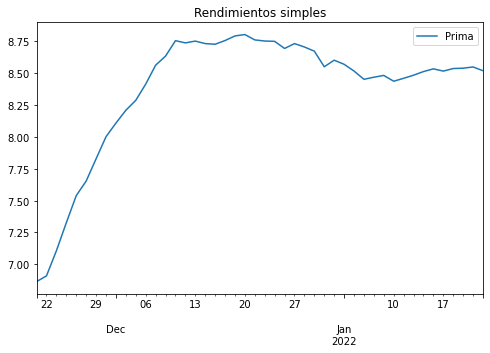

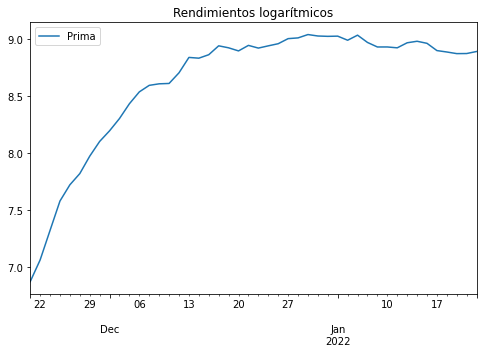

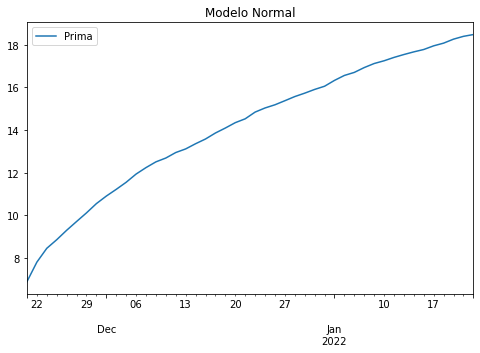

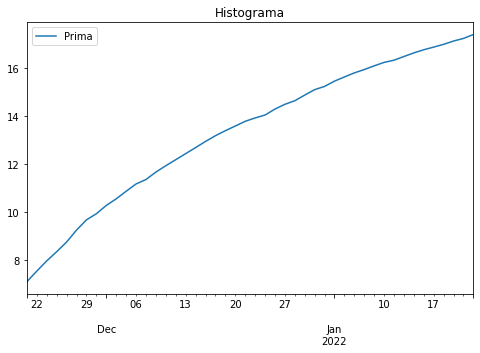

In [8]:
# Valoración a través de distintos métodos
metodos = ["Rendimientos simples", "Rendimientos logarítmicos", "Modelo Normal", "Histograma"]
primas = pd.DataFrame([valuacionPut(ticker, fechaInicio, precioEjercicio, fechaExpiracion, rf, N, metodo) 
                       for metodo in metodos],
                       columns = ["Prima", "Límite inferior (99% confianza)", "Límite superior (99% confianza)"], 
                       index = metodos)

primas["% Error relativo (prima real)"] = np.round(abs(primas["Prima"] - primaReal) / primaReal * 100, 2)
primas["% Error relativo (prima teórica B&S)"] = np.round(abs(primas["Prima"] - primaTeorica) / primaTeorica * 100, 2)
primas

Por último se valora el contrato por distintos métodos:

+ Simulación de precios a través de rendimientos simples.
+ Simulación de precios a través de rendimientos logarítmicos.
+ Modelo normal de los rendimientos.
+ Uso del histograma de los rendimientos.

Puede constatarse que la valoración por medio de la simulación de precios a través de los **rendimientos simples** y los **rendimientos logarítmicos** arroja las primas que más discrepan de la prima real y la prima teórica obtenida con Black and Scholes. Lo anterior se debe a que estos modelos de valoración asumen como tasa de descuento a la media de los rendimientos históricos del activo subyacente, supuesto que no es muy certero en los mercados.

Por otra parte, el **modelo normal de los rendimientos** y el **histograma de los rendimientos** arrojan las primas que más se acercan a la prima real y a la prima teórica. Esto puede deberse a que la tasa de descuento usada no es la media de los rendimientos históricos, sino una tasa libre de riesgo. Por lo que concluimos que estos métodos son los más certeros para la valoración de opciones financieras, pues sus estimaciones son las que más se acercan al valor real al que se comercian dichos contratos.

Cabe mencionar que para todas las primas calculadas se computa un intervalo de confianza (al $99\%$). Esto quiere decir que las primas que observamos para cada método estarán dentro del límite inferior y el límite superior en el $99\%$ de las ocasiones. 